In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# coding: utf-8
 
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

In [3]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
#%time km.fit(tfidf_matrix)
tfidf_matrix=np.load('/content/drive/MyDrive/data/test/embedding1.npy')[:10000]
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [5]:
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
print(xs, ys)

[ 0.01353149  0.01471199  0.00942717 ... -0.00145585 -0.00150743
 -0.00278842] [-0.00704868 -0.00417309 -0.0073391  ...  0.00308732  0.00180836
  0.00036689]


In [6]:
#构造词典，统计每个词的频率，并根据频率将每个词转换为一个整数id
def load_text8():
    with open("/content/drive/MyDrive/data/test/new1.txt", "r") as f:
        corpus = f.read().strip("\n")
    f.close()
    return corpus
corpus = load_text8()
#打印前800个字符，简要看一下这个语料的样子
print(corpus[:800])

def data_preprocess(corpus):
    #由于英文单词出现在句首的时候经常要大写，所以我们把所有英文字符都转换为小写，
    #以便对语料进行归一化处理（Apple vs apple等）
    corpus = corpus.strip().lower()
    corpus = corpus.split()
    return corpus
corpus = data_preprocess(corpus)
print(corpus[:50])
hi=corpus

def build_dict(corpus):
    #首先统计每个不同词的频率（出现的次数），使用一个词典记录
    word_freq_dict = dict()
    for word in corpus:
        if word not in word_freq_dict:
            word_freq_dict[word] = 0
        word_freq_dict[word] += 1
    #将这个词典中的词，按照出现次数排序，出现次数越高，排序越靠前
    #一般来说，出现频率高的高频词往往是：I，the，you这种代词，而出现频率低的词，往往是一些名词，如：nlp
    word_freq_dict = sorted(word_freq_dict.items(), key = lambda x:x[1], reverse = True)    
    #构造3个不同的词典，分别存储，
    #每个词到id的映射关系：word2id_dict
    #每个id出现的频率：word2id_freq
    #每个id到词典映射关系：id2word_dict
    word2id_dict = dict()
    word2id_freq = dict()
    id2word_dict = dict()
    #按照频率，从高到低，开始遍历每个单词，并为这个单词构造一个独一无二的id
    for word, freq in word_freq_dict:
        curr_id = len(word2id_dict)
        word2id_dict[word] = curr_id
        word2id_freq[word2id_dict[word]] = freq
        id2word_dict[curr_id] = word
    return word2id_freq, word2id_dict, id2word_dict
word2id_freq, word2id_dict, id2word_dict = build_dict(corpus)
vocab_size = len(word2id_freq)
print("there are totoally %d different words in the corpus" % vocab_size)
for _, (word, word_id) in zip(range(50), word2id_dict.items()):
    print("word %s, its id %d, its word freq %d" % (word, word_id, word2id_freq[word_id]))


recombination every day  abundant recombination in a virus during a single multi cellular host infectionas increasing numbers of full length viral sequences become available  recombinant or mosaic viruses are being recognized more frequently          recombination events have been demonstrated to be associated with viruses expanding their host range           or increasing their virulence        thus accompanying  or perhaps even being at the origin of  major changes during virus adaptation  it remains unclear  however  whether recombination events represent a highly frequent and significant phenomenon in the everyday life of these viruses why can t i visit  the ethics of visitation restrictions   lessons learned from sarsthe sudden emergence of severe acute respiratory syndrome  sars  in 
['recombination', 'every', 'day', 'abundant', 'recombination', 'in', 'a', 'virus', 'during', 'a', 'single', 'multi', 'cellular', 'host', 'infectionas', 'increasing', 'numbers', 'of', 'full', 'length'

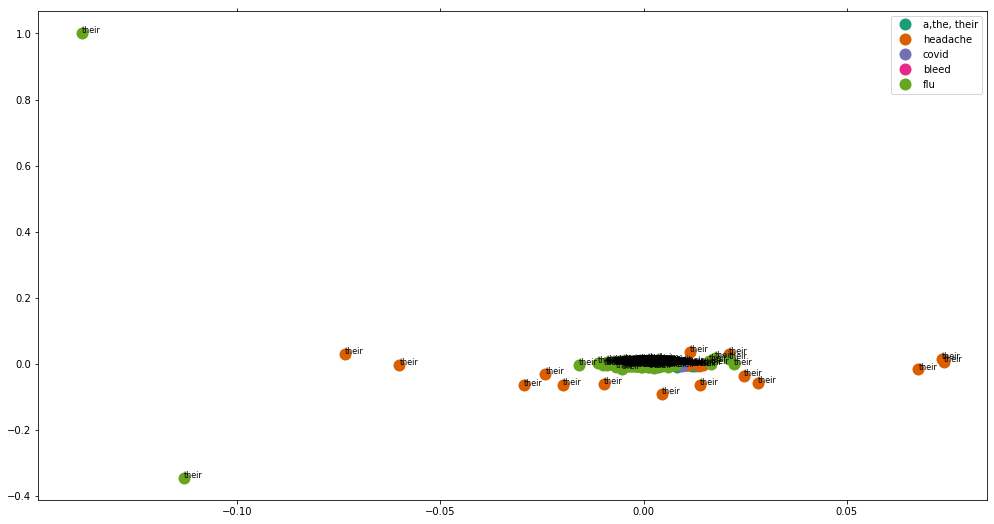

In [11]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {0:"a,the, their",
                 1: 'headache', 
                 2: 'covid', 
                 3: 'bleed', 
                 4: 'flu'}
#some ipython magic to show the matplotlib plots inline
#%matplotlib inline 
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=word)) 
#group by cluster
groups = df.groupby('label')
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')    
ax.legend(numpoints=1)  #show legend with only 1 point
#add label in x,y position with the label as the film title
for i in range(len(df)):
    #与loc不同的之处是，.iloc 是根据行数与列数来索引的
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  
plt.show() #show the plot
#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)
#plt.close()

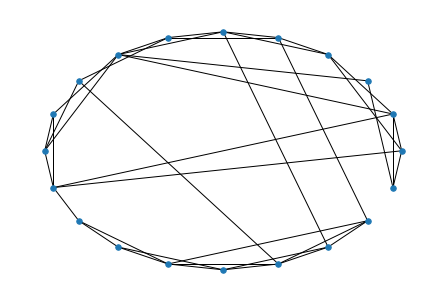

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
WS = nx.random_graphs.watts_strogatz_graph(20,4,0.3)
#生成包含20个节点、每个节点4个近邻、随机化重连概率为0.3的小世界网络
pos = nx.circular_layout(WS) 
#定义一个布局，此处采用了circular布局方式，没有这个布局更像一张乱网而不是一个圈
nx.draw(WS,pos,with_labels=False,node_size = 30)  #绘制图形
plt.show()
